## Runing the simultaion

In [212]:
%matplotlib inline  
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

def sigmoid(x, sigma, mu):
    return 1 / (1 + math.exp(-sigma * (x - mu)))


class Neuron:
    def __init__(self, rest, length):
        self.v = np.ones(length) * rest
        self.exCons = {}
        self.inhCons = {}
        self.gjCons = {}
        self.input = -1
        self.current_from_neurons=np.zeros(length)


def createNeurons(num, rest, length):
    neurons = []
    for i in range(num):
        neurons.append(Neuron(rest, length))
    return neurons


def createSynapses(neurons, synapses):
    for syn in synapses['inp']:
        neurons[syn[1]].input = syn[0]
    for syn in synapses['inh']:
        neurons[syn[1]].inhCons[syn[0]] = syn[2]
    for syn in synapses['ex']:
        neurons[syn[1]].exCons[syn[0]] = syn[2]
    for syn in synapses['gj']:
        neurons[syn[1]].gjCons[syn[0]] = syn[2]


def testParamSetting(testingParams, topology, inp):
    G_leak= testingParams['G_leak']
    V_leak= testingParams['V_leak']
    C_m= testingParams['C_m']
    delT= testingParams['delT']
    E_rev_in= testingParams['E_rev_in']
    E_rev_ex= testingParams['E_rev_ex']
    sigma= testingParams['sigma']
    mu= testingParams['mu']
    rest= testingParams['rest']
    def eulerStepForNeuron(t, neuron, neurons,inputs):
        summedInh = 0
        summedEx = 0
        summedGJ = 0
        summedGJWithPre = 0
        if neuron.input != -1:
            neuron.v[t + 1] = (((C_m / delT) *
                                neuron.v[
                                    t] + G_leak * V_leak + summedInh * E_rev_in + summedEx * E_rev_ex + summedGJWithPre) / \
                               (C_m / delT + G_leak + summedInh + summedEx + summedGJ))+inputs[neuron.input, t]
            return
        for inh,w in neuron.inhCons.items():
            summedInh += sigmoid(neurons[inh].v[t], sigma, mu) * w
        for ex,w in neuron.exCons.items():
            summedEx += sigmoid(neurons[ex].v[t], sigma, mu) * w
        for gj,w in neuron.gjCons.items():
            summedGJ += w
            summedGJWithPre += w * neurons[gj].v[t]
        neuron.v[t + 1] = (((C_m / delT) *
        neuron.v[t] + G_leak * V_leak + summedInh * E_rev_in + summedEx * E_rev_ex + summedGJWithPre) / \
                          (C_m / delT + G_leak + summedInh + summedEx + summedGJ))
        return

    inp_len = len(inp[0, :])
    neurons = createNeurons(topology['num'], rest, inp_len)
    createSynapses(neurons, topology['syn'])

    for t in range(inp_len-1):
        for i, neuron in enumerate(neurons):
            eulerStepForNeuron(t, neuron, neurons, inp)
    return neurons



#default params



simulationRanges={
    'G_leak' : (0.1,6 ),
    'V_leak' :  (-0.075,-0.065 ),
    'C_m' : (0.01, 1),
    'delT' : (.001, .01),
    'E_rev_in' :  (1, 1),
    'E_rev_ex' :  (1, 1),
    'sigma' :  (1, 1),
    'mu' : (1, 1),
    'rest' : (1, 1)
}

defaultParams={
    'G_leak' :  1,
    'V_leak' : -0.07,
    'C_m' : 0.05,
    'delT' : 0.01,
    'E_rev_in' : -0.09,
    'E_rev_ex' : 0,
    'sigma' : 250,
    'mu' : -0.02,
    'rest' : -0.07
}


topology = {
    'num': 3, #num of neurons
    'syn': {
        'inp': [(0,0)],  # input -> neuron
        'inh': [],  # input neuron , output neuron , weigth (1, 2,1)
        'ex': [
            [0, 1,5,[1,1000] ]
        ],  # input neuron , output neuron , weigth, weigth ranges
        'gj': []  # input neuron , output neuron , weigth
    }
}

length = 800
inp = np.ones([1,length])*0
inp[0,100:200]=.01

#inp[0,100:200]=np.linspace(0,0.1,100)
#inp[0,300:400]=np.linspace(0.1,0,100)




# statistics functions

def get_rise_time(neurons):
    max_v=np.max(neurons)
    start_v=neurons[0]
    above_start=np.argmax(neurons > (start_v + abs(start_v - max_v)*0.1))
    above_max=np.argmax(neurons > (start_v + abs(start_v - max_v)*0.9))
    return above_max-above_start

def get_fall_time(neurons):
    max_v=np.max(neurons)
    start_v=neurons[0]
    max_value_achieved=np.argmax(neurons = max_v)
    fall_start=np.argmax(neurons[max_value_achieved:] < (start_v + abs(start_v - max_v)*0.9))
    fall_end=np.argmax(neurons[max_value_achieved:] < (start_v + abs(start_v - max_v)*0.1))
    return fall_end-fall_start

def parse_the_weight(w):
    sub=w.split('_')
    return sub[1],int(sub[2])

def testRanges2D(params,points_per_axis,num_of_neuron):

    param_ranges={
        'px':[],
        'py':[],
    }
    num_of_neurons_total=topology['num']
    neurons_vs = np.zeros([points_per_axis,points_per_axis,length])
       

    for i,pR in enumerate(param_ranges.keys()):
        if params[i][:2]=='w_':
            w_type,w_type_num=parse_the_weight(params[i])
            lower_bound = topology['syn'][w_type][w_type_num][3][0]
            upper_bound = topology['syn'][w_type][w_type_num][3][1]          
        else:
            lower_bound = simulationRanges[params[i]][0]
            upper_bound = simulationRanges[params[i]][1]
        param_ranges[pR] = np.linspace(lower_bound,upper_bound,points_per_axis)
    for i, p0 in enumerate(param_ranges['px']) :
        for j, p1 in enumerate(param_ranges['py']):
                if params[0][:2]=='w_': 
                    w_type,type_num=parse_the_weight(params[0])
                    topology['syn'][w_type][type_num][2]=p0
                    defaultParams[params[1]]=p1
                elif params[1][:2]=='w_':
                    w_type,type_num=parse_the_weight(params[1])
                    topology['syn'][w_type][type_num][2]=p1
                    defaultParams[params[0]]=p0
                elif params[1][:2]=='w_' and params[0][:2]=='w_':
                    w_type,type_num=parse_the_weight(params[1])
                    topology['syn'][w_type][type_num][2]=p1
                    w_type,type_num=parse_the_weight(params[0])
                    topology['syn'][w_type][type_num][2]=p0
                else:
                    defaultParams[params[0]]=p0
                    defaultParams[params[1]]=p1
                neurons = testParamSetting(defaultParams, topology, inp)
                neurons_vs[i][j]=neurons[num_of_neuron].v
 
    return neurons_vs,param_ranges
param_plots=[
    ('G_leak','C_m'),
    #('G_leak', 'V_leak'),
    #('G_leak', 'w_ex_0')
    ]
arr_of_neuron_vs=[]           
arr_of_param_ranges=[]           
for i,p_s in enumerate(param_plots):
    neurons_vs,param_ranges=testRanges2D(p_s,30,1)
    arr_of_neuron_vs.append(neurons_vs)
    arr_of_param_ranges.append(param_ranges)
print "done with simulation"

done with simulation


## Ploting the simulation results

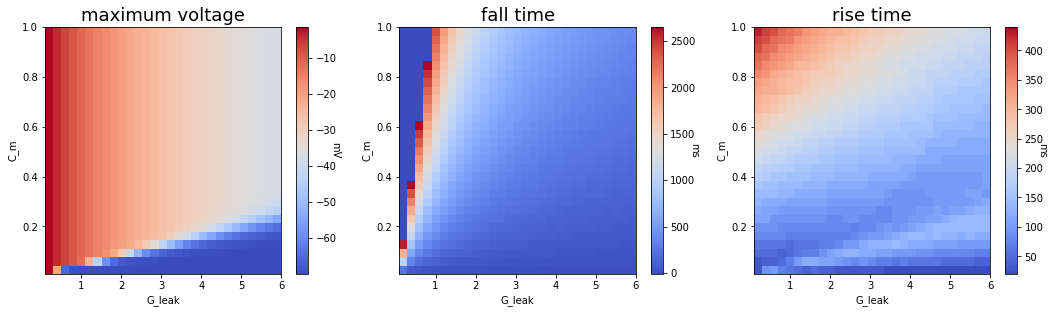

In [213]:
import matplotlib.gridspec as gridspec


def get_fall_time(neurons):
    max_v=np.max(neurons)
    start_v=neurons[0]
    max_value_achieved=np.argmax(neurons == max_v)
    fall_start=np.argmax(neurons[max_value_achieved:] < (start_v + abs(start_v - max_v)*0.9))
    fall_end=np.argmax(neurons[max_value_achieved:] < (start_v + abs(start_v - max_v)*0.1))
    delta_t=fall_end-fall_start
    if delta_t < 0:
        delta_t = -1
    return delta_t


def decor_subplot(ax,title,paramNames):
    ax.set_xlabel(paramNames[0])
    ax.set_ylabel(paramNames[1])
    ax.set_title(title,fontsize=18)

def plotParamRanges(neurons_vs,param_ranges,stat_functions,plot_params, cols_per_row=3):
    points_per_axis=len(param_ranges['px'])
    number_of_statistics=len(stat_functions)
    resultsOfSim = np.zeros([points_per_axis,points_per_axis,number_of_statistics])
    for i in range(points_per_axis) :
        for j in range(points_per_axis):
            for k in range(number_of_statistics):
                resultsOfSim[i][j][k]= stat_functions[k][0](neurons_vs[i][j])*stat_functions[k][2] # [k][0] kth function is stored in first parameter [k][2]-scaling param
    
    num_of_rows=(number_of_statistics / cols_per_row )+1
    wr=[1 for i in range(cols_per_row)]
    hr=[1 for i in range(num_of_rows)]
    fig = plt.figure(figsize=(6*cols_per_row,5*num_of_rows))
    fig.set_facecolor("white")
    gs = gridspec.GridSpec(num_of_rows, cols_per_row,width_ratios=wr,height_ratios=hr)
    #fig, axes = plt.subplots(ncols=3,nrows=num_of_rows, sharex=True, sharey=True)
    for k in range(number_of_statistics):
        ax = fig.add_subplot(gs[k])
        #plt.subplot(num_of_rows, cols_per_row, k+1,aspect='equal')
        minim=np.min(resultsOfSim[:,:,k])
        maxim=np.max(resultsOfSim[:,:,k])
        plt.pcolor(param_ranges['px'], param_ranges['py'], resultsOfSim[:,:,k].T, cmap='coolwarm', vmin=minim, vmax=maxim)
        decor_subplot(ax,stat_functions[k][1],plot_params)
        # set the limits of the plot to the limits of the data
        plt.axis([param_ranges['px'].min(), param_ranges['px'].max(), param_ranges['py'].min(), param_ranges['py'].max()])
        cbar=plt.colorbar()
        cbar.ax.set_ylabel(stat_functions[k][3], rotation=270)
    plt.show()

# ploting parameters ( function, fn name, scaling factor for units, unit name)
statistic_functions=[
    (np.max,"maximum voltage",1000, 'mV'),
    (get_fall_time,"fall time",10, 'ms'),
    (get_rise_time,"rise time",10, 'ms')
]

for i,p_s in enumerate(param_plots):
    plotParamRanges(arr_of_neuron_vs[i],arr_of_param_ranges[i],statistic_functions,p_s)

def plotVoltage(arr_of_neuron_vs,params,stat_fns):
    for p in params:
        for fn in stat_fns:
            print fn[1]+": "+ str(fn[0](arr_of_neuron_vs[p[2]][p[0]][p[1]])*fn[2]) + fn[3]
        plt.plot(arr_of_neuron_vs[p[2]][p[0]][p[1]])
        plt.show()


## ploting the graphs

maximum voltage: -0.219927538723mV
fall time: 410ms
rise time: 20ms


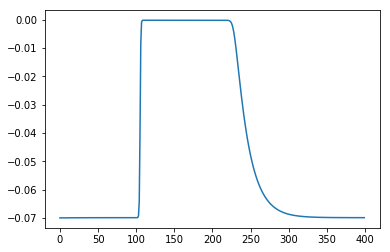

In [201]:
points=[
    (15,15,0), #first param, second param, num of the plot
]
plotVoltage(arr_of_neuron_vs,points,statistic_functions)

In [ ]:
print np.max(neurons_vs[16][0])
print resultsStatistics[16][0]
plt.plot(neurons_vs[16][0])
plt.show()
print get_fall_time(neurons_vs[8][25])
print resultsStatistics[8][25]
plt.plot(neurons_vs[8][25])
plt.show()


In [184]:
w='w_ex_5'
a=w.split('_')
a

['w', 'ex', '5']